# Load Data (Init)

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
import joblib

all_features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
selected_features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram']
# selected_features = ['battery_power', 'area', 'ram']
target = 'price_range'

In [3]:
# Load the training data
data_train_path = '/content/data_train.csv'
data_train = pd.read_csv(data_train_path)

data_validation_path = '/content/data_validation.csv'
data_validation = pd.read_csv(data_validation_path)

# data_test = '/content/test.csv'
# data_test = pd.read_csv(data_test)

# KNN From Scratch

In [4]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

class KNNPredictor:
    def __init__(self, data_train, selected_columns, k, distance_metric):
        self.data_set = data_train
        self.selected_columns = selected_columns
        self.k = k
        self.distance_metric = distance_metric

    # Fungsi utama buar prediksi
    def predict(self, test_data_list):
        new_data_set = self.data_set[self.selected_columns + ["price_range"]]
        test_data_array = np.array(test_data_list)
        predicted_price_ranges = []

        for test_data in test_data_array:
            if self.distance_metric == 'euclidean':
                distances = np.sqrt(np.sum((new_data_set[self.selected_columns].values - test_data) ** 2, axis=1))
            # Manhattan
            elif self.distance_metric == 'manhattan':
              distances = np.sum(np.abs(new_data_set[self.selected_columns].values - test_data), axis=1)
            elif self.distance_metric == 'minkowski':
              p = 3
              distances = np.power(np.sum(np.abs(new_data_set[self.selected_columns].values - test_data) ** p, axis=1), 1/p)
            # chebyshev
            else:
              distances = np.max(np.abs(new_data_set[self.selected_columns].values - test_data), axis=1)

            #Sort by distance
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_price_ranges = new_data_set.iloc[nearest_indices]["price_range"]

            #Ambil nilai terbanyak/majority vote
            predicted_price_range = nearest_price_ranges.mode()[0]
            predicted_price_ranges.append(predicted_price_range)

        return predicted_price_ranges

    def save(self, path):
      joblib.dump(self, path)

    def load(self, path):
      loaded_model = joblib.load(path)
      self.data_set = loaded_model.data_set
      self.selected_columns = loaded_model.selected_columns
      self.k = loaded_model.k
      self.distance_metric = loaded_model.distance_metric



In [5]:
from sklearn.metrics import classification_report

## SAVE MODEL
model_save_path = "/knn_demo.pkl"
knn_predictor = KNNPredictor(data_train, selected_features, k=5, distance_metric="euclidean")
knn_predictor.save(model_save_path)

## LOAD MODEL
loaded_knn_predictor = KNNPredictor(None, None, 0, "")  # Create a dummy instance
loaded_knn_predictor.load(model_save_path)
loaded_validation_predictions = loaded_knn_predictor.predict(data_validation[selected_features])

classification_rep = classification_report(data_validation['price_range'], loaded_validation_predictions)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       142
           1       0.91      0.87      0.89       144
           2       0.89      0.91      0.90       155
           3       0.97      0.94      0.96       159

    accuracy                           0.93       600
   macro avg       0.92      0.93      0.92       600
weighted avg       0.93      0.93      0.92       600



#KNN Library

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

X_train = data_train[selected_features]
y_train = data_train['price_range']

X_validation = data_validation[selected_features]
y_validation = data_validation['price_range']

params = {
    'n_neighbors': 5,
    'metric': 'euclidean',
    'weights': 'uniform'
}

best_knn = KNeighborsClassifier(**params, n_jobs=-1)
best_knn.fit(X_train, y_train)

validation_predictions = best_knn.predict(X_validation)

classification_rep = classification_report(y_validation, validation_predictions)
print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       142
           1       0.91      0.87      0.89       144
           2       0.89      0.91      0.90       155
           3       0.97      0.94      0.96       159

    accuracy                           0.93       600
   macro avg       0.92      0.93      0.92       600
weighted avg       0.93      0.93      0.92       600



Notes: Kalo mau dapet 0.9660 di kaggle harus pake k = 3 dan featuresnya adalah selected_features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram']

Ada yang menarik nih:
Pake Chebysev dan K=19 test data accuracynya 0.9383, tapi kmrn di kaggle pas gw K=19 malah nurun accuracynya

Best Model yet:
K=3
Distance=Chebysev
Acc=0.9690 (Naik 0.003) atau 0.3% awkawk


# Kaggle Submission

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def add_area(df):
  df["area"] = df["px_width"] * df["px_height"]

scaler = MinMaxScaler()

def get_normalized_df(data, selected_columns, train=False):
    selected_data = data[selected_columns]
    normalized_data=None
    if (train):
      print("creating new scaler...")
      normalized_data = scaler.fit_transform(selected_data)
    else:
      print("using old scaler...")
      normalized_data = scaler.transform(selected_data)

    normalized_df = pd.DataFrame(normalized_data, columns=selected_columns)

    remaining_columns = data.drop(columns=selected_columns)
    result_df = pd.concat([normalized_df, remaining_columns], axis=1)

    return result_df

In [ ]:
def weigh(df, weights):
    """
    Weigh specified columns in the DataFrame.

    Parameters:
    - df: Pandas DataFrame
    - weights: Dictionary of column weights

    Returns:
    - Pandas DataFrame with specified columns weighted
    """
    weighted_df = df.copy()

    for column, weight in weights.items():
        # Check if the column exists in the DataFrame
        if column in weighted_df.columns:
            weighted_df[column] *= weight
        else:
            print(f"Column '{column}' not found in the DataFrame.")

    return weighted_df

def compare_reference(knn_model, reference_csv_path, weights):
  X_test = data_test[selected_features]
  X_test = weigh(X_test, weights)
  predicted_price_ranges = knn_model.predict(X_test)

  submission_df = pd.DataFrame({
      'id': data_test['id'],
      'price_range': predicted_price_ranges
  })

  submission = submission_df

  path_to_submission_before = reference_csv_path
  submission_before = pd.read_csv(path_to_submission_before)

  if submission_before['id'].equals(submission['id']):
    differences = (submission_before['price_range'] != submission['price_range']).sum()
    total = len(submission_before)
    percentage_difference = (differences / total) * 100
    return percentage_difference

    print(f'Total changes: {differences} out of {total} predictions ({percentage_difference:.2f}%)')
  else:
    print('The IDs in both submission files do not match, or they are not in the same order.')


## Data di kaggle:
1. Di add area
2. Di normalize
3. Di weighting


BESGT PARAMS K 1 DISC EUCLIDEAN EWITH WEIGHTS kek biasa

In [ ]:
selected_features = ['battery_power', 'area', 'ram', 'px_width', 'px_height', 'mobile_wt', 'int_memory']
target = 'price_range'

# Load the training data
data_train_path = '/content/data_train.csv'
data_train = pd.read_csv(data_train_path)
add_area(data_train)
data_train = get_normalized_df(data_train, selected_features, train=True)

data_validation_path = '/content/data_validation.csv'
data_validation = pd.read_csv(data_validation_path)
add_area(data_validation)
data_validation = get_normalized_df(data_validation, selected_features)

data_test = '/content/test.csv'
data_test = pd.read_csv(data_test)
add_area(data_test)
data_test = get_normalized_df(data_test, selected_features)

creating new scaler...
using old scaler...
using old scaler...


In [ ]:
## SEE BElow For wegithS tuning
weights = {"ram": 5, "area": 4, "battery_power": 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.1, 'int_memory': 0.1}
weights = {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}
def check_predictions(predictions, actuals):
    correct = sum(p == a for p, a in zip(predictions, actuals))
    return correct / len(actuals)

data_train_weighted = weigh(data_train, weights)
data_val_weighted = weigh(data_validation, weights)
knn_model = KNNPredictor(data_train_weighted, selected_features, k=1, distance_metric = "euclidean")
predictions = knn_model.predict(data_val_weighted[selected_features])

validation_accuracy = check_predictions(predictions, data_validation['price_range'])
validation_accuracy_str = "{:.4f}".format(validation_accuracy)
print(f"The accuracy of the KNN model dist on the validation set is: {validation_accuracy:.4f}")
filename = 'knn_' + "_ver_" + str(validation_accuracy_str) + ".pkl"
knn_model.save(filename)

The accuracy of the KNN model dist on the validation set is: 0.9150


In [ ]:
# test_df = data_test
# loaded_knn_predictor = KNNPredictor(None, None, 0, "")  # Create a dummy instance
# loaded_knn_predictor.load(filename)
loaded_knn_predictor = knn_model

X_test = data_test[selected_features]
X_test_weighted = weigh(X_test, weights)
predicted_price_ranges = loaded_knn_predictor.predict(X_test_weighted)

submission_df = pd.DataFrame({
    'id': data_test['id'],
    'price_range': predicted_price_ranges
})

submission_file_path = "/content/submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to {submission_file_path}")


Submission file saved to /content/submission.csv


In [ ]:
## TO compare with prefision submision
import pandas as pd

# Submission before itu submission pas gw dapet 0.9660
path_to_submission_before = '/content/submission_before.csv'
path_to_submission_before = '/content/submission_CATBOST.csv'
path_to_submission = '/content/submission.csv'

submission_before = pd.read_csv(path_to_submission_before)
submission = pd.read_csv(path_to_submission)

if submission_before['id'].equals(submission['id']):
    differences = (submission_before['price_range'] != submission['price_range']).sum()
    total = len(submission_before)
    percentage_difference = (differences / total) * 100

    print(f'Total changes: {differences} out of {total} predictions ({percentage_difference:.2f}%)')
else:
    print('The IDs in both submission files do not match, or they are not in the same order.')

Total changes: 41 out of 2000 predictions (2.05%)


## Best parameters for validation set: (Euclidean)
{'ram': 6, 'area': 6, 'battery_power': 1}
Best accuracy on validation set: 0.9150

Best parameters for reference:
{'ram': 5, 'area': 4, 'battery_power': 1}
Least difference with reference: 3.8500

Best parameters for validation set:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.7000000000000001, 'px_height': 1.7000000000000006}
Best accuracy on validation set: 0.9267

Best parameters for reference:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.30000000000000004, 'px_height': 0.30000000000000004}
Least difference with reference: 3.6500


# Sampe saat ini baru dapet parameter buat 5 variabel ini. Kalo mau coba, tambahin selected features lagi terus jalanin loopnya.

# Minkowskki
Best parameters for validation set:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.30000000000000004, 'px_height': 0.7}
Best accuracy on validation set: 0.9267

Best parameters for reference:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9000000000000001, 'px_height': 1.1}
Least difference with reference: 3.4000

output
Best parameters for validation set:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.1, 'int_memory': 0.1}
Best accuracy on validation set: 0.9217

Best parameters for reference:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.1, 'int_memory': 0.1}
Least difference with reference: 3.4000

In [ ]:
REFERENCE_COMPARISON = '/content/submission_CATBOST.csv'
distance_metric_types = ['euclidean', 'minkowski', 'manhattan', 'cheb']
k_vals = [1,2,3,4,5,6,7,8,9,10,11]
best_ref_accuracy = 100
best_ref_params = {}

best_validation_accuracy = 0
best_validation_params = {}

# for area in np.arange(0.1, 1, 0.15):
#   for ram in np.arange(area, 1, 0.15):
for k_val in k_vals:
  for distance_metric_type in distance_metric_types:
    # knn_model = KNNPredictor(data_train, selected_features, k=k_val, distance_metric = distance_metric_type)
    # predictions = knn_model.predict(data_validation[selected_features])
    weights = {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}
    data_train_weighted = weigh(data_train, weights)
    data_val_weighted = weigh(data_validation, weights)
    knn_model = KNNPredictor(data_train_weighted, selected_features, k=5, distance_metric = "minkowski")
    knn_model = KNNPredictor(data_train_weighted, selected_features, k=k_val, distance_metric = distance_metric_type)
    predictions = knn_model.predict(data_val_weighted[selected_features])
    def check_predictions(predictions, actuals):
        correct = sum(p == a for p, a in zip(predictions, actuals))
        return correct / len(actuals)
    validation_accuracy = check_predictions(predictions, data_validation['price_range'])
    validation_accuracy_str = "{:.4f}".format(validation_accuracy)
    ref_dist = compare_reference(knn_model, REFERENCE_COMPARISON, weights)
    print(f"The accuracy of the KNN model dist on the validation set is: {validation_accuracy:.4f}, difference with reference {ref_dist : .4f} : weights - {weights}:{distance_metric_type} : {k_val}")
            # Update best parameters for validation set
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      best_validation_params = weights
        # Update best parameters for reference
    if ref_dist < best_ref_accuracy:
      best_ref_accuracy = ref_dist
      best_ref_params = weights
    filename = 'knn_' + "_ver_" + str(validation_accuracy_str) + "_ref_" + str(ref_dist) + ".pkl"
    joblib.dump(knn_model, filename)

The accuracy of the KNN model dist on the validation set is: 0.9150, difference with reference  2.0500 : weights - {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}:euclidean : 1
The accuracy of the KNN model dist on the validation set is: 0.9083, difference with reference  2.3000 : weights - {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}:minkowski : 1
The accuracy of the KNN model dist on the validation set is: 0.9117, difference with reference  2.2000 : weights - {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}:manhattan : 1
The accuracy of the KNN model dist on the validation set is: 0.9200, difference with reference  2.6500 : weights - {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}:cheb : 1
The accuracy of the KNN model

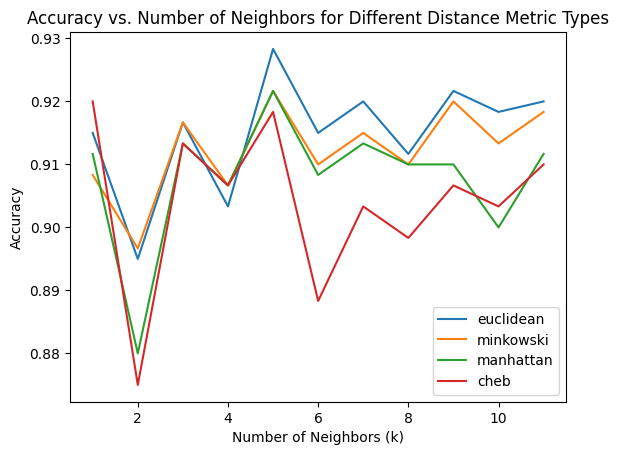

In [ ]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store accuracy values for each distance metric type
accuracy_per_metric = {metric: [] for metric in distance_metric_types}

for distance_metric_type in distance_metric_types:
    # Reset best_validation_accuracy for each metric type
    best_validation_accuracy = 0
    best_validation_params = {}

    for k_val in k_vals:
        weights = {'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}
        data_train_weighted = weigh(data_train, weights)
        data_val_weighted = weigh(data_validation, weights)

        knn_model = KNNPredictor(data_train_weighted, selected_features, k=k_val, distance_metric=distance_metric_type)
        predictions = knn_model.predict(data_val_weighted[selected_features])

        validation_accuracy = check_predictions(predictions, data_validation['price_range'])

        # Update best parameters for validation set
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_validation_params = weights

        # Append accuracy for the current k_val to the corresponding metric type
        accuracy_per_metric[distance_metric_type].append(validation_accuracy)

# Plotting
for distance_metric_type in distance_metric_types:
    plt.plot(k_vals, accuracy_per_metric[distance_metric_type], label=distance_metric_type)

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors for Different Distance Metric Types')
plt.legend()
plt.show()


In [ ]:
print("Best parameters for validation set:")
print(best_validation_params)
print(f"Best accuracy on validation set: {best_validation_accuracy:.4f}")

print("\nBest parameters for reference:")
print(best_ref_params)
print(f"Least difference with reference: {best_ref_accuracy:.4f}")

Best parameters for validation set:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}
Best accuracy on validation set: 0.9283

Best parameters for reference:
{'ram': 5, 'area': 4, 'battery_power': 1, 'px_width': 0.9, 'px_height': 1.1, 'mobile_wt': 0.4, 'int_memory': 0.25}
Least difference with reference: 2.0500
